<a href="https://colab.research.google.com/github/sj442/Predicting-podcast-listening-time/blob/main/S5e4_Podcast_Listening_time_GBDT_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Regression #RMSE
from google.colab import files
files.upload()

In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!pip install catboost
!pip install optuna

In [3]:
import catboost
from catboost import CatBoostRegressor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, TargetEncoder, MinMaxScaler

In [5]:
# Synthetic dataset for competition
! kaggle competitions download -c playground-series-s5e4

# Original dataset
! kaggle datasets download ysthehurricane/podcast-listening-time-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/ysthehurricane/podcast-listening-time-prediction-dataset
License(s): apache-2.0


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

!pip install cuml-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

# Data

In [7]:
import zipfile

with zipfile.ZipFile('playground-series-s5e4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

with zipfile.ZipFile('podcast-listening-time-prediction-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

In [8]:
train = pd.read_csv('/content/kaggle/train.csv')
test = pd.read_csv('/content/kaggle/test.csv')
sub = pd.read_csv('/content/kaggle/sample_submission.csv')
orig = pd.read_csv('/content/kaggle/podcast_dataset.csv')

In [9]:
Target = 'Listening_Time_minutes'
categorical_features = train.select_dtypes(include='object').columns.tolist()
numerical_features = train.select_dtypes(exclude='object').columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in (Target, 'id')]

In [10]:
orig = orig.dropna(subset=[Target])

# High level stats

In [ ]:
# Display basic info
print(train.info())  # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [ ]:
train.describe(include='object')

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,750000,750000,750000,750000,750000,750000
unique,48,100,10,7,4,3
top,Tech Talks,Episode 71,Sports,Sunday,Night,Neutral
freq,22847,10515,87606,115946,196849,251291


In [ ]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [ ]:
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       0 non-null       float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [ ]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,NaN,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,NaN,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,NaN,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,NaN,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,NaN,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


# Cleaning & Imputing missing values

There are 2 columns with missing values: Episode length in minutes and guest popularity percentage

In [11]:
train_ads_median = train[train.Number_of_Ads.notna()].Number_of_Ads.median()
train.Number_of_Ads = train.Number_of_Ads.fillna(train_ads_median)

train_median = train[train.Episode_Length_minutes.notna()].Episode_Length_minutes.median()
test_median = test[test.Episode_Length_minutes.notna()].Episode_Length_minutes.median()
orig_median = orig[orig.Episode_Length_minutes.notna()].Episode_Length_minutes.median()

train.Episode_Length_minutes = train.Episode_Length_minutes.fillna(train_median)
test.Episode_Length_minutes =  test.Episode_Length_minutes.fillna(test_median)
orig.Episode_Length_minutes = orig.Episode_Length_minutes.fillna(orig_median)

In [12]:
train_median = train[train.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()
test_median = test[test.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()
orig_median = orig[orig.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()

train.Guest_Popularity_percentage = train.Guest_Popularity_percentage.fillna(train_median)
test.Guest_Popularity_percentage =  test.Guest_Popularity_percentage.fillna(test_median)
orig.Guest_Popularity_percentage = orig.Guest_Popularity_percentage.fillna(orig_median)

In [13]:
for col in categorical_features:
  train[col] = train[col].astype('category')
  test[col] = test[col].astype('category')
  orig[col] = orig[col].astype('category')

# Encoding categorical features

In [14]:
day_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train['Publication_Day_num'] = train.Publication_Day.map(day_map)
test['Publication_Day_num'] = test.Publication_Day.map(day_map)
orig['Publication_Day_num'] = orig.Publication_Day.map(day_map)

In [ ]:
print(train.Publication_Time.unique())

['Night' 'Afternoon' 'Evening' 'Morning']


In [15]:
time_map = {'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}

train['Publication_Time_num'] = train.Publication_Time.map(time_map)
test['Publication_Time_num'] = test.Publication_Time.map(time_map)
orig['Publication_Time_num'] = orig.Publication_Time.map(time_map)

In [16]:
def extract_episode_number(title):
  epi_num = title.split(" ")[-1]
  return int(epi_num)

train['Episode_n'] = train.Episode_Title.apply(extract_episode_number)
test['Episode_n'] = test.Episode_Title.apply(extract_episode_number)
orig['Episode_n'] = orig.Episode_Title.apply(extract_episode_number)

In [17]:
import cuml
from cuml.preprocessing import TargetEncoder

In [ ]:
print(train.Genre.unique())

['True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music'
 'Sports' 'Business' 'Lifestyle']


In [ ]:
print(train.Episode_Sentiment.unique())

['Positive' 'Negative' 'Neutral']


In [18]:
sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}

train['Episode_Sentiment_num'] = train.Episode_Sentiment.map(sentiment_map)
test['Episode_Sentiment_num'] = test.Episode_Sentiment.map(sentiment_map)
orig['Episode_Sentiment_num'] = orig.Episode_Sentiment.map(sentiment_map)

In [ ]:
print(train.Podcast_Name.unique())

['Mystery Matters' 'Joke Junction' 'Study Sessions' 'Digital Digest'
 'Mind & Body' 'Fitness First' 'Criminal Minds' 'News Roundup'
 'Daily Digest' 'Music Matters' 'Sports Central' 'Melody Mix' 'Game Day'
 'Gadget Geek' 'Global News' 'Tech Talks' 'Sport Spot' 'Funny Folks'
 'Sports Weekly' 'Business Briefs' 'Tech Trends' 'Innovators'
 'Health Hour' 'Comedy Corner' 'Sound Waves' 'Brain Boost'
 "Athlete's Arena" 'Wellness Wave' 'Style Guide' 'World Watch' 'Humor Hub'
 'Money Matters' 'Healthy Living' 'Home & Living' 'Educational Nuggets'
 'Market Masters' 'Learning Lab' 'Lifestyle Lounge' 'Crime Chronicles'
 'Detective Diaries' 'Life Lessons' 'Current Affairs' 'Finance Focus'
 'Laugh Line' 'True Crime Stories' 'Business Insights' 'Fashion Forward'
 'Tune Time']


In [19]:
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
train['Name_n'] = TE.fit_transform(train.Podcast_Name, train[Target])
test['Name_n'] = TE.transform(test.Podcast_Name)
orig['Name_n'] = TE.transform(orig.Podcast_Name)

In [20]:
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
train['Genre_n'] = TE.fit_transform(train.Genre, train[Target])
test['Genre_n'] = TE.transform(test.Genre)
orig['Genre_n'] = TE.transform(orig.Genre)

In [38]:
print(train.columns)

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes', 'Publication_Day_num',
       'Publication_Time_num', 'Episode_n', 'Episode_Sentiment_num', 'Name_n',
       'Genre_n'],
      dtype='object')


In [60]:
print(numerical_features)
numerical_features.extend(['Genre_n', 'Name_n', 'Episode_n', 'Publication_Day_num', 'Publication_Time_num', 'Episode_Sentiment_num'])

['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']


In [61]:
print(numerical_features)

['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Genre_n', 'Name_n', 'Episode_n', 'Publication_Day_num', 'Publication_Time_num', 'Episode_Sentiment_num']


# XGBoost



In [ ]:
import xgboost as xgb

X = train.drop(columns=[Target, 'id'])
y = train[Target]

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "device": "cuda",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_scores = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        score = root_mean_squared_error(y_valid, preds)  # RMSE
        val_scores.append(score)

    return np.mean(val_scores)

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [22]:
print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

Best params: {'learning_rate': 0.021504954292546015, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 4.444180330716101, 'subsample': 0.9783301042033197, 'colsample_bytree': 0.6261560696207955, 'lambda': 0.0013836471098856024, 'alpha': 7.621035442622206}
Best RMSE: 12.686377784161774


In [38]:
# Note: when I run XGBoost again with the best study params with the same CV scheme, i get a much higher RMSE.
# Likely happening due to difference in `num_boost_rounds`, difference in random state at some step or incorrect casting of
# some params returned by optuna
X = train.drop(columns=[Target, 'id'])
y = train[Target]

xgb_params = {}
xgb_params['objective'] = "reg:squarederror"
xgb_params['enable_categorical'] = True
xgb_params['tree_method'] = 'hist'
xgb_params['device'] = 'cuda'
xgb_params['eval_metric'] = 'rmse'

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = xgb.XGBRegressor(**xgb_params)

        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        score = root_mean_squared_error(y_valid, preds)
        val_scores.append(score)

print(f'Average RMSE: {np.mean(val_scores)}')

Average RMSE: 13.07130091833344


In [40]:
test_preds = model.predict(test.drop(columns=['id']))
sub[Target] = test_preds
sub.to_csv('submission_xgb.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

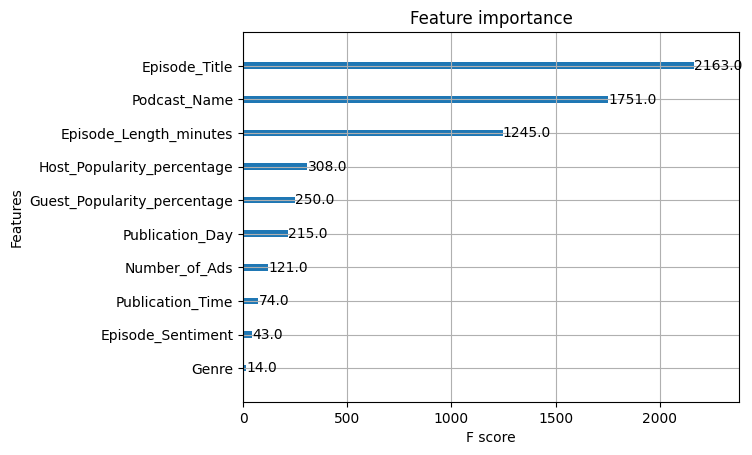

In [39]:
# Interesting to note that episode title and podcast name are the more important features in XGBoost.
# In linear regression, epiode length was the most significant. Both podcast name and episode title had low
# significance in linear regression.
from xgboost import plot_importance
plot_importance(model)

In [41]:
# Retrain the model on the full training data
# Note: No change in LB between the CV model and model trained on full training data
X = train.drop(columns=[Target, 'id'])
y = train[Target]

xgb_params = {}
xgb_params['objective'] = "reg:squarederror"
xgb_params['enable_categorical'] = True
xgb_params['tree_method'] = 'hist'
xgb_params['device'] = 'cuda'
xgb_params['eval_metric'] = 'rmse'

model = xgb.XGBRegressor(**xgb_params)

model.fit(X_train, y_train)
preds = model.predict(X_train)
score = root_mean_squared_error(y_train, preds)

print(f'Train RMSE: {score}')

test_preds = model.predict(test.drop(columns=['id']))
sub[Target] = test_preds
sub.to_csv('submission_xgb_full.csv', index=False)

Train RMSE: 12.37873450155665


# Other tree models

In [22]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor


catboost_params = {
    "iterations": 1000,
    "depth": 6,
    "l2_leaf_reg": 3,
    "random_strength": 1,
    "bagging_temperature": 1,
    "border_count": 128,
    "loss_function": "RMSE",
    "early_stopping_rounds": 50,
    "task_type": "GPU",
    "verbose": False,
    'cat_features': categorical_features
}

lgbm_params = {
    "n_estimators": 1000,
    "max_depth": -1,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "metric": "rmse",
    'verbose': -1
}

adaboost_params = {
    "n_estimators": 200,
    "loss": "linear"
}


rf_params = {
    "n_estimators": 500,
    "max_depth": 10,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "max_features": "sqrt",
    "bootstrap": True,
    "n_jobs": -1
}

et_params = {
    "n_estimators": 500,
    "max_depth": 10,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "max_features": "sqrt",
    "bootstrap": False,
    "n_jobs": -1
}

catboost_features = train.drop(columns=[Target, 'id', 'Genre_n', 'Name_n', 'Episode_n', 'Publication_Day_num', 'Publication_Time_num', 'Episode_Sentiment_num']).columns.tolist()
gbdt_features = numerical_features

# Catboost

In [69]:
X = train[catboost_features]
y = train[Target]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_idx, valid_idx in kf.split(train):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

  model = CatBoostRegressor(**catboost_params)
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  score = root_mean_squared_error(y_valid, preds)

  val_scores.append(score)

print(f'Average Catboost RMSE: {np.mean(val_scores)}')

Average Catboost RMSE: 13.09663624215653


In [73]:
X = train[gbdt_features]
y = train[Target]

models = ['LGBM', 'AdaBoost', 'RandomForest', 'ExtraTrees']
params = [lgbm_params, adaboost_params, rf_params, et_params]

for model, param in zip(models, params):
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  val_scores = []
  fold = 1

  for train_idx, valid_idx in kf.split(train):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    if model == 'LGBM':
      model = LGBMRegressor(**param)
    elif model == 'AdaBoost':
      model = AdaBoostRegressor(**param)
    elif model == 'RandomForest':
      model = RandomForestRegressor(**param)
    elif model == 'ExtraTrees':
      model = ExtraTreesRegressor(**param)

    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    score = root_mean_squared_error(y_valid, preds)
    print(f'{model} Fold {fold} RMSE: {score}')
    val_scores.append(score)
    fold += 1

print(f'{model} Average RMSE: {np.mean(val_scores)}')

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, metric='rmse', min_data_in_leaf=20,
              n_estimators=1000, verbose=-1) Fold 1 RMSE: 12.95694219422571
LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, metric='rmse', min_data_in_leaf=20,
              n_estimators=1000, verbose=-1) Fold 2 RMSE: 13.0035886091626
LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, metric='rmse', min_data_in_leaf=20,
              n_estimators=1000, verbose=-1) Fold 3 RMSE: 12.997713527299977
LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, metric='rmse', min_data_in_leaf=20,
              n_estimators=1000, verbose=-1) Fold 4 RMSE: 12.997788676004843
LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
     

In [76]:
fold_1 = [12.95694219422571, 13.593142649445234, 13.439043963871782, 14.192047829789432]
fold_2 = [13.0035886091626, 13.95835160390515, 13.473059726552043, 15.019096498589347]
fold_3 = [12.997713527299977, 13.701750988723926, 13.484477463078917, 14.878535363366137]
fold_4 = [12.997788676004843, 13.677498116281887, 13.471713201195607, 14.960716909064903]
fold_5 = [12.961325371895141, 13.762542633193526, 13.47341815020826, 14.852156212537666]

custom_palette = ["#FF5733", "#33FF57", "#5733FF", "#FFFF33"]

df = pd.DataFrame(data={'Fold 1': fold_1, 'Fold 2': fold_2, 'Fold 3': fold_3, 'Fold 4': fold_4, 'Fold 5': fold_5})
df['model'] = ['LGBM', 'AdaBoost', 'RandomForest', 'ExtraTrees']
df = df.melt(id_vars='model', var_name='fold', value_name='RMSE')
print(df)

           model    fold       RMSE
0           LGBM  Fold 1  12.956942
1       AdaBoost  Fold 1  13.593143
2   RandomForest  Fold 1  13.439044
3     ExtraTrees  Fold 1  14.192048
4           LGBM  Fold 2  13.003589
5       AdaBoost  Fold 2  13.958352
6   RandomForest  Fold 2  13.473060
7     ExtraTrees  Fold 2  15.019096
8           LGBM  Fold 3  12.997714
9       AdaBoost  Fold 3  13.701751
10  RandomForest  Fold 3  13.484477
11    ExtraTrees  Fold 3  14.878535
12          LGBM  Fold 4  12.997789
13      AdaBoost  Fold 4  13.677498
14  RandomForest  Fold 4  13.471713
15    ExtraTrees  Fold 4  14.960717
16          LGBM  Fold 5  12.961325
17      AdaBoost  Fold 5  13.762543
18  RandomForest  Fold 5  13.473418
19    ExtraTrees  Fold 5  14.852156


<Axes: xlabel='fold', ylabel='RMSE'>

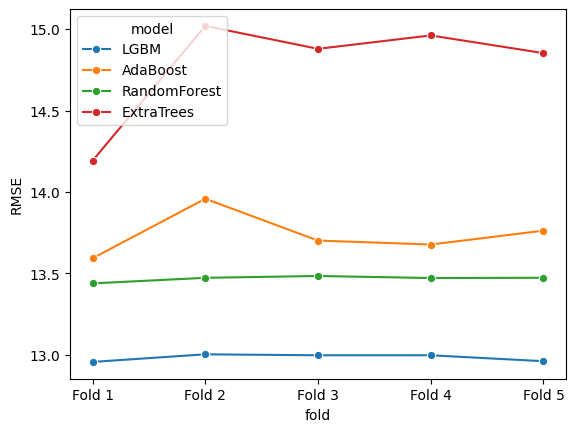

In [81]:
sns.lineplot(data=df, x='fold', y='RMSE', hue='model', marker="o")

# Light GBM tuning

Since Light GBM outperforms XGBoost, we will optimize it further with GridSearchCV

In [ ]:
# This was taking too long because of the large size of dataset. So using default params instead
X = train[gbdt_features]
y = train[Target]

# define the model with default hyperparameters
model = LGBMRegressor(metric='rmse', verbose=-1, n_estimators=500, random_state=42)
# define the grid of values to search

param_grid = {
    'max_depth': [4, 6, 8],
    'lambda_l1': [0, 0.5],
    'lambda_l2': [0, 0.5],
}

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [27]:
from re import L
from sklearn.model_selection import GridSearchCV
# define dataset

X = train[gbdt_features]
y = train[Target]

model = LGBMRegressor(metric='rmse', verbose=-1, n_estimators=500, random_state=42)

model.fit(X, y)
preds = model.predict(test[gbdt_features])
sub[Target] = preds
sub.to_csv('submission_lgbm.csv', index=False)

In [28]:
train_preds = model.predict(train[gbdt_features])
print(root_mean_squared_error(train[Target], train_preds))

orig_preds = model.predict(orig[gbdt_features])
print(root_mean_squared_error(orig[Target], orig_preds))

12.901311160476963
13.744271839770073
